# PPO + ICM on Unity Pyramids

Required installation includes:
* install Unity
* install all Unity API libraries: ml-agents, ml-agents-envs, gym-unity
* build an executable for Pyramids example
* fix "number of agents changed!" issue: assertion is removed (by some reason, 32 agents instead of 16 are returned on dones)

In [1]:
from gym_unity.envs import UnityEnv

In [2]:
# Loading LegoRL library
import sys
sys.path.append('..\\LegoRL')  # path to folder with library

from LegoRL import *

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import gym

# Environment

In [4]:
env = UnityEnv("./Pyramids/Unity Environment.exe",
                 worker_id=0,                   # ?!?
                 flatten_branched=True,         # returns Discrete action space instead of trivial MultiDiscrete
                 use_visual=False,              # use raycasts as observations instead of pictures
                 multiagent=True,               # there are 16 parallel agents in the Unity scene
                 no_graphics=False)             # show game window

INFO:mlagents_envs:Connected new brain:
Pyramids?team=0
INFO:gym_unity:16 agents within environment.


In [5]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(172,)
Action space: Discrete(5)


In [6]:
# kludge to imitate Vectorized Environment from OpenAI codebase
# and fight some Unity inner demons...

class VEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.num_envs = 16
        
        self.button = np.zeros((16,))
        self.T = np.zeros((16,))
        
    def step(self, a):
        # Unity wants list as actions
        a = a.tolist()
        
        # Step!
        s, r, done, info = self.env.step(a) 
        
        # Unity dev has weird issues
        if len(r) != 16: raise Exception("WTF?")
        
        # We prefer numpy
        s = np.array(s)
        r = np.array(r)
        done = np.array(done)
        
        # Unity last tick bug!
        self.T += 1
        r += (r == 0) * (self.T < 1000)
        self.T[done] = 0
        
        # Storing information about button pushing
        info = [{"button": self.button[i]} for i in range(16)]
        self.button += 1 - s[:, -4]
        self.button[done] = 0
        
        return s, r, done, info
    
    def reset(self):
        # helpers
        self.button = np.zeros((16,))
        self.T = np.zeros((16,))
        
        # We prefer numpy
        s = self.env.reset()
        return np.array(s)
    
env = VEnv(env)

# Network

In [7]:
PyramidsNetwork = lambda input_size, output_size: nn.Sequential(
    nn.Linear(input_size, 150),
    nn.ReLU(),
    nn.Linear(150, 100),
    nn.ReLU(),
    nn.Linear(100, output_size),
    nn.ReLU()
)

# ICM

### Feature Extractor (filter)

In [8]:
PyramidsFilter = lambda input_size, output_size: nn.Sequential(
    nn.Linear(input_size, 100),
    nn.ReLU(),
    nn.Linear(100, output_size),
    nn.Tanh()
)

### Dynamics Models

In [9]:
PyramidsInverse = lambda input_size, output_size: nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

In [10]:
PyramidsForward = lambda input_size, output_size: nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )

# Model

In [11]:
PPO = lambda runner: Composed(
    rollout      = RolloutCollector(runner=runner, rollout_length=128),    
    backbone     = Backbone(PyramidsNetwork, embedding_size=100),
    policy       = PolicyHead(backbone="backbone"),
    critic       = ValueHead(backbone="backbone"),
    gae          = GAE(evaluator="critic"),
    sampler      = EpochedRollout(rollout="rollout"),
    actor_loss   = ProximalLoss(sampler="sampler", policy="policy", target="gae"),
    critic_loss  = CriticLoss(sampler="sampler", critic="critic", target="gae"),
    entropy_loss = EntropyLoss(sampler="sampler", policy="policy"),      
    trainer      = Trainer(transformations=["backbone", "policy", "critic"], 
                            losses=["actor_loss", "critic_loss", "entropy_loss"],
                            weights=[1, 1, 0.001], 
                            optimizer_args={"lr": 0.0001}, clip_gradients=10)
)

In [12]:
ICM = lambda sampler: Composed(
    state_filter  = Backbone(PyramidsFilter, embedding_size=100),
    inverse       = InverseDynamics(backbone="state_filter", network=PyramidsInverse),
    inverse_loss  = DynamicsLoss(sampler=sampler, model="inverse"),
    forward       = ForwardDynamics(backbone="state_filter", network=PyramidsForward),
    forward_loss  = DynamicsLoss(sampler=sampler, model="forward"),    
    trainer       = Trainer(transformations=["state_filter", "inverse", "forward"], 
                            losses=["inverse_loss", "forward_loss"],
                            weights=[1, 1], 
                            optimizer_args={"lr": 0.0001}, clip_gradients=10)
)

In [13]:
agent = Composed(
    visualizer = Visualizer(timer=500),
    runner     = Runner(policy="ppo.policy", env_max_T=1000, log_info=[("button", "time till button push")], frozen=True),
    motivated  = IntrinsicMotivation(runner="runner", motivations=["icm.forward"], coeffs=[0.01]),
    ppo        = PPO(runner="motivated"),
    icm        = ICM(sampler="ppo.sampler")
)

In [14]:
agent

<visualizer>: Plots logs every 500 iteration
<runner>: Makes one step in 1 parallel environments each 1 iteration using <ppo.policy> policy
<motivated>: Adds intrinsic rewards from <['icm.forward']> with weights [0.01] to stream from <runner>
<ppo>:
    <rollout>: Collects rollouts of length 128 from <motivated>
    <backbone>: Feature extractor network
    <policy>: Head, modeling Discrete Policy
    <critic>: Head, modeling V-function
    <gae>: Estimates GAE returns using <critic> to evaluate last state and <critic> as baseline
    <sampler>: Performs 3 epoches with batches of size 32 using rollouts from <rollout>
    <actor_loss>: Calculates PPO gradient estimation for <policy> using samples from <sampler>
    <critic_loss>: Calculates TD loss for <critic> using <gae> as target calculator and data from <sampler>
    <entropy_loss>: Calculates entropy penalty for <policy> using rollouts from <sampler>
    <trainer>: Trains <backbone>, <policy>, <critic> using following losses: <acto

# Initialization issues

In [15]:
system = System(agent, gamma=0.999, folder_name="Models/Pyramids PPO ICM take2", save_timer=5000, env=env, already_vectorized=True)

Initializing <ppo.backbone>:
  Input shape is torch.Size([172])
  Output shape is torch.Size([100])
Initializing <ppo.policy>:
  Input shape is torch.Size([100])
  Output shape is torch.Size([5])
Initializing <ppo.critic>:
  Input shape is torch.Size([100])
  Output shape is torch.Size([])
Initializing <icm.state_filter>:
  Input shape is torch.Size([172])
  Output shape is torch.Size([100])
Initializing <icm.inverse>:
  Input shape is torch.Size([200])
  Output shape is torch.Size([5])
Initializing <icm.forward>:
  Input shape is torch.Size([105])
  Output shape is torch.Size([100])


# LOAD

In [16]:
# loading model from backup
#system.load()

In [17]:
# some issues during training, had to reload :(
#system.reload_messages

# RUN

In [18]:
system.run(debug=True)

ppo.trainer: initiates loss computation.
  runner: plays one step.
    ppo.policy: received act query.


..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


      ppo.backbone: forward pass output for current computed.
      ppo.policy: forward pass output for current computed.
  motivated: cold start regime, no intrinsic motivation.
  ppo.rollout: resets because runner was reset.
  ppo.rollout: not enough transitions collected.
  ppo.sampler: new rollout is not generated yet.
  ppo.actor_loss: no batch is found, loss is None.
ppo.trainer: loss is None; no optimization step is performed.
icm.trainer: initiates loss computation.
  ppo.sampler: returns same sample.
  icm.inverse_loss: no batch is found, loss is None.
icm.trainer: loss is None; no optimization step is performed.


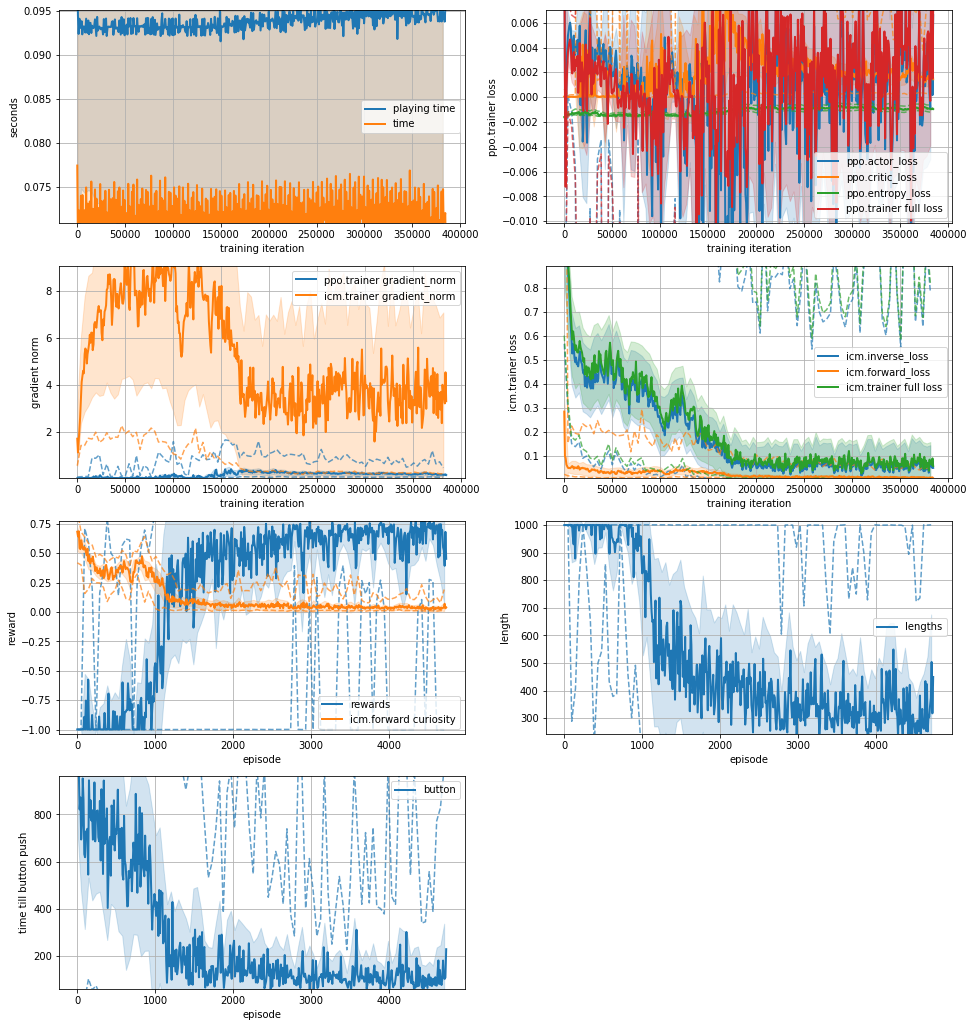

KeyboardInterrupt: 

In [19]:
system.run(700000)   # 350 000

In [20]:
system.save()

# Training statistics

In [23]:
print("Learning time in hours: ", sum(system.logger['time']) / 60 / 60)
print("Viz. time in hours: ", sum(system.logger['visualization time']) / 60 / 60)
print("Frames done: ", agent.runner.frames_done)
print("Fps: ", agent.runner.frames_done / sum(system.logger['time']))
print("Episodes played: ", agent.runner.episodes_done)

Learning time in hours:  7.674627200497522
Viz. time in hours:  0.5594377730952369
Frames done:  2478080
Fps:  89.6923769158366
Episodes played:  4745


Text(0.5, 0, 'episode')

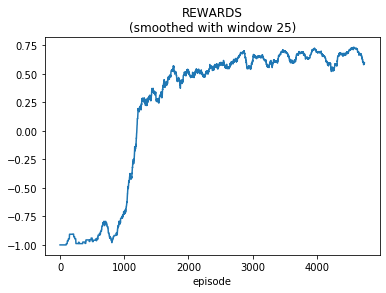

In [22]:
from LegoRL.utils.visualizer import sliding_average
plt.plot(sliding_average(system.logger['rewards'], 100))
plt.title("REWARDS\n(smoothed with window 25)")
plt.xlabel("episode")